In [19]:
library(tidyverse)
#library(janeaustenr)
library(textshape)
library(tm)
library(tidytext)
library(readr)
library(ggplot2)
library(RTextTools)
library(reshape)
library(quanteda)
library(naivebayes)
library(e1071)

### Load data

In [20]:
train_dataset <- read.csv('train.csv')

str(train_dataset)

'data.frame':	10240 obs. of  3 variables:
 $ Labels  : int  1 2 3 1 2 5 0 2 2 3 ...
 $ Text    : chr  "Says the Annies List political group supports third-trimester abortions on demand." "When did the decline of coal start? It started when natural gas took off that started to begin in (President Ge"| __truncated__ "Hillary Clinton agrees with John McCain \"by voting to give George Bush the benefit of the doubt on Iran.\"" "Health care reform legislation is likely to mandate free sex change surgeries." ...
 $ Text_Tag: chr  "abortion" "energy,history,job-accomplishments" "foreign-policy" "health-care" ...


In [21]:
# remove text duplicates if exists
train_dataset <- train_dataset[!duplicated(train_dataset$Text),]

str(train_dataset)

'data.frame':	10223 obs. of  3 variables:
 $ Labels  : int  1 2 3 1 2 5 0 2 2 3 ...
 $ Text    : chr  "Says the Annies List political group supports third-trimester abortions on demand." "When did the decline of coal start? It started when natural gas took off that started to begin in (President Ge"| __truncated__ "Hillary Clinton agrees with John McCain \"by voting to give George Bush the benefit of the doubt on Iran.\"" "Health care reform legislation is likely to mandate free sex change surgeries." ...
 $ Text_Tag: chr  "abortion" "energy,history,job-accomplishments" "foreign-policy" "health-care" ...


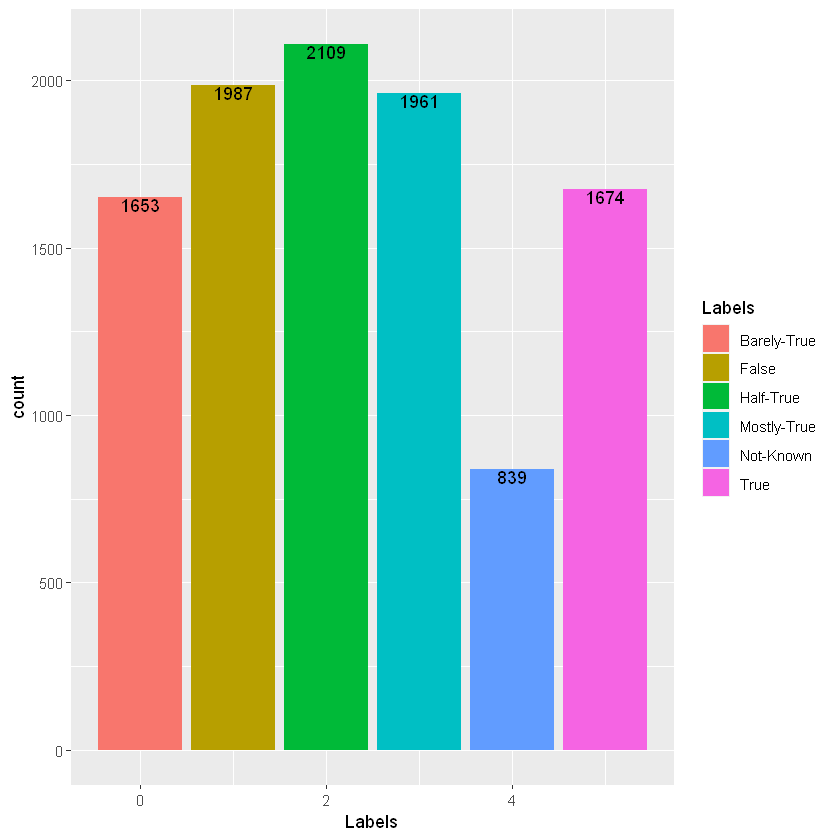

In [27]:
ggplot(train_dataset, aes(x = Labels, fill=as.factor(Labels))) +
  geom_bar(stat="count")+
  geom_text(stat='count', aes(label=..count..), vjust=1) +
  scale_fill_discrete(name = "Labels", 
                      labels=c('Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True')
                      )

### Split data in train, validation and test

In [25]:
# Sample into 3 sets.
idx <- sample(seq(1, 2), size = nrow(train_dataset), replace = TRUE, prob = c(.8, .2))

train_data <- train_dataset[idx == 1,]
validation_data <- train_dataset[idx == 2,]
test_data <- read.csv('test.csv')

# create a numeric id for each sentence
train_data$id <- seq.int(nrow(train_data))
test_data$id <- seq.int(nrow(test_data))
validation_data$id <- seq.int(nrow(validation_data))

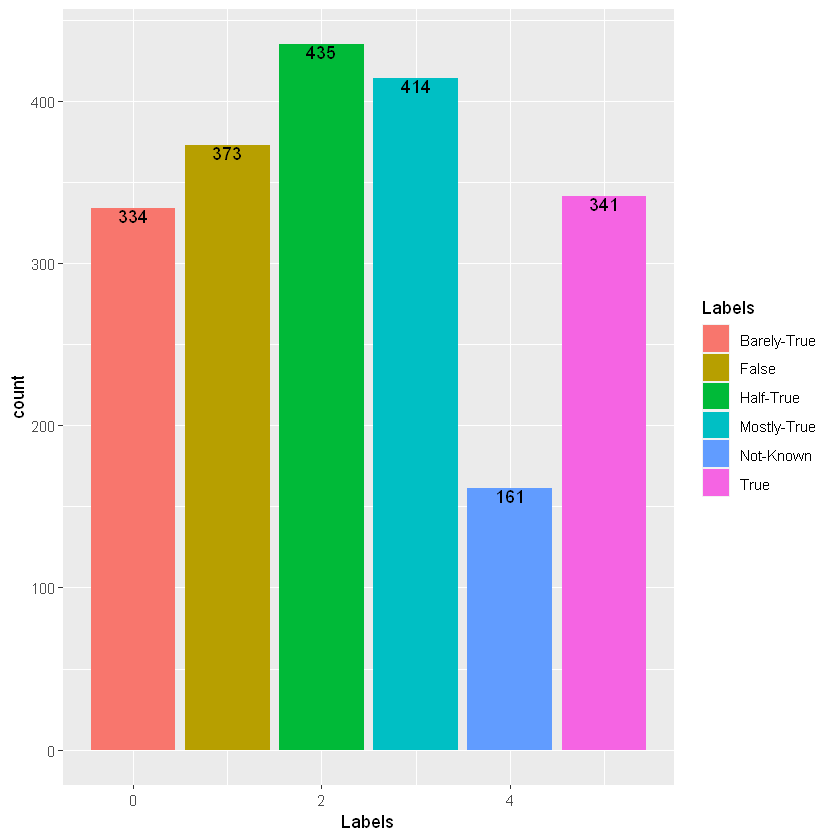

In [26]:
ggplot(validation_data, aes(x = Labels, fill=as.factor(Labels))) +
  geom_bar(stat="count")+
  geom_text(stat='count', aes(label=..count..), vjust=1) +
  scale_fill_discrete(name = "Labels", 
                      labels=c('Barely-True', 'False', 'Half-True', 'Mostly-True', 'Not-Known', 'True')
                      )

In [28]:
y <- train_data$Labels

unique_labels <- unique(y)
counts <- table(y)
proportions <- counts / length(y)

# Calculate Shannon entropy
shannon_entropy <- -sum(proportions * log(proportions))

cat("Shannon entropy:", shannon_entropy, "\n")

Shannon entropy: 1.757546 


### Data pre-process

In [294]:
clean_text <- function(df){
    df <- df %>%
            mutate(Text = removePunctuation(Text)) %>%
            # Tokenize and Lower words
            unnest_tokens(word, Text, to_lower = TRUE) %>%
            # Remove stop words
            anti_join(stop_words) %>%
            # Remove numbers
            filter(!grepl('[0-9]', word))
}

df <- clean_text(train_data)
str(df)

Joining with `by = join_by(word)`


'data.frame':	68821 obs. of  4 variables:
 $ Labels  : int  1 1 1 1 1 1 1 2 2 2 ...
 $ Text_Tag: chr  "abortion" "abortion" "abortion" "abortion" ...
 $ id      : int  1 1 1 1 1 1 1 2 2 2 ...
 $ word    : chr  "annies" "list" "political" "supports" ...


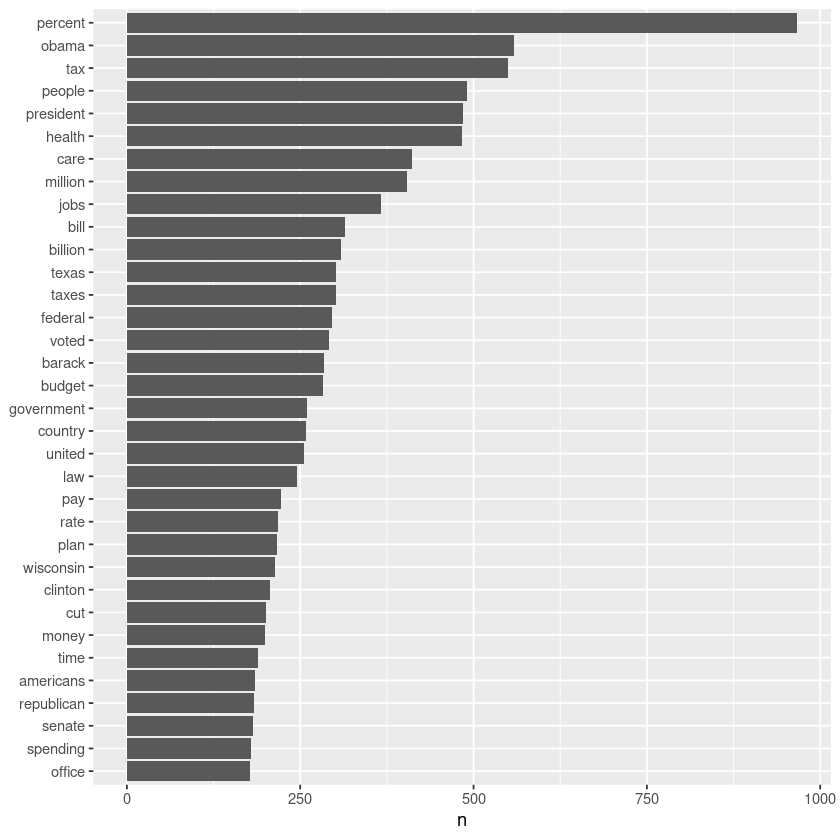

In [295]:
# Count number of words
df_count <- df %>% count(word, sort = TRUE) 

# Plot words that repeat more than 175 times
df_count %>% mutate(word=reorder(word, n)) %>% 
        filter(n > 175) %>%
        ggplot(aes(word, n)) +
        geom_col() +
        xlab(NULL) +
        coord_flip()

In [296]:
str(df_count)

'data.frame':	10610 obs. of  2 variables:
 $ word: chr  "percent" "obama" "tax" "people" ...
 $ n   : int  967 559 550 490 485 483 411 404 366 315 ...


In [297]:
#Word Cloud of Train Dataset
#library(wordcloud)
#wordcloud(Data_test_corpus_clean, min.freq = 40, random.order = FALSE)

### Stemming

In [298]:
stemming_text <- function(df){
    df <- df %>%
        mutate(stem = stemDocument(word))             
}

df <- stemming_text(df)
str(df)

'data.frame':	68821 obs. of  5 variables:
 $ Labels  : int  1 1 1 1 1 1 1 2 2 2 ...
 $ Text_Tag: chr  "abortion" "abortion" "abortion" "abortion" ...
 $ id      : int  1 1 1 1 1 1 1 2 2 2 ...
 $ word    : chr  "annies" "list" "political" "supports" ...
 $ stem    : chr  "anni" "list" "polit" "support" ...


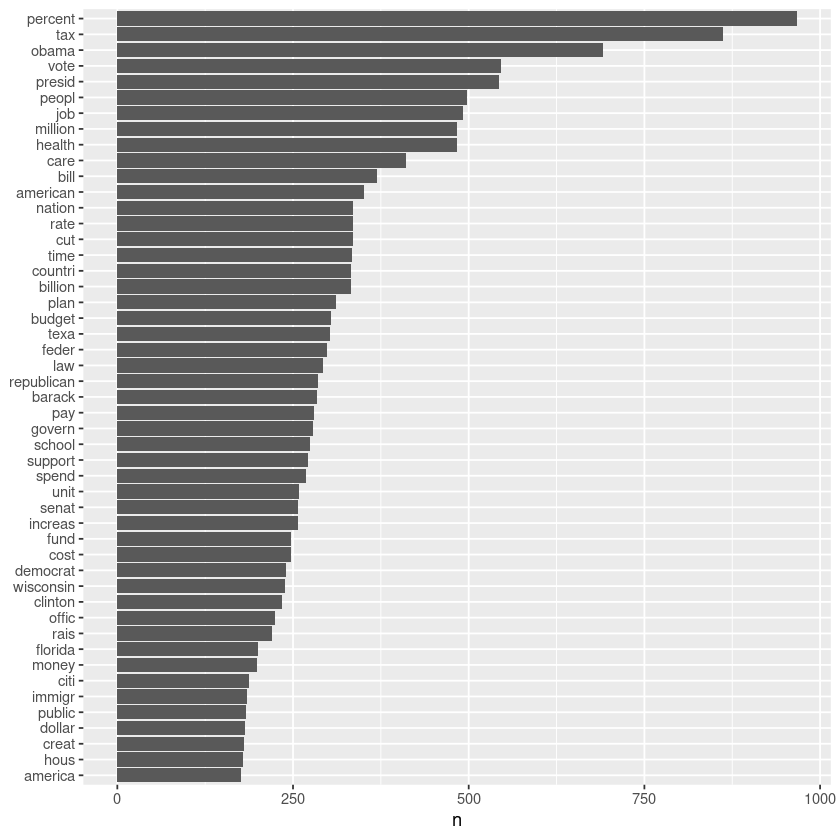

In [299]:
# Count number of stem words
df_count <- df %>% count(stem, sort = TRUE) 

# Plot stem words that repeat more than 175 times
df_count %>% mutate(stem=reorder(stem, n)) %>% 
        filter(n > 175) %>%
        ggplot(aes(stem, n)) +
        geom_col() +
        xlab(NULL) +
        coord_flip()

In [300]:
str(df_count)

'data.frame':	7386 obs. of  2 variables:
 $ stem: chr  "percent" "tax" "obama" "vote" ...
 $ n   : int  967 862 691 546 543 497 492 484 483 411 ...


In [301]:
# Vizualize final data set after preprocessing

df %>% select(Labels, id, stem) %>% nest_by(Labels, id) %>% arrange(id)

Labels,id,data
<int>,<int>,"<list<tibble[,1]>>"
1,1,"anni , list , polit , support , thirdtrimest, abort , demand"
2,2,"declin , coal , start , start , natur , gas , start , begin , presid , georg , bush , administr"
3,3,"hillari, clinton, agre , john , mccain , vote , georg , bush , benefit, doubt , iran"
1,4,"health , care , reform , legisl , mandat , free , sex , chang , surgeri"
2,5,"econom , turnaround, start , term"
5,6,"chicago , bear , start , quarterback, total , tenur , uw , faculti , fire , decad"
0,7,"jim , dunnam , live , district, repres"
3,8,"gop , primari , oppon , glenn , grothman , joe , leibham , cast , compromis, vote , cost , million , electr , cost"
3,9,"time , histori, share , nation , popular, vote , margin , latino , vote , margin"


### Data processing

In [305]:
# Count the number of words per line
perb <- df %>%
  count(Labels, id, stem, sort = TRUE) %>%
  ungroup()

# calculate the overall words in the documents
peridc <- perb %>%
  group_by(id) %>%
  summarize(total = sum(n))

# Dataframe with the information of words and how many appearences per sentences
book_words <- left_join(perb, peridc)
head(book_words)

Joining with `by = join_by(id)`


,Labels,id,stem,n,total
,<int>,<int>,<chr>,<int>,<int>
1,2,3005,tax,8,22
2,2,305,percent,6,17
3,3,1025,republican,6,230
4,0,6604,democrat,5,30
5,1,4967,fund,5,13
6,3,1025,island,5,230


### Multinomial Naive-Bayes 

- Implementing Document-feature matrix

A sparse matrix is a matrix where most of the elements are zero. When working with text data, we say our data is “sparse” because most documents do not contain most words, resulting in a representation of mostly zeroes. There are special data structures and algorithms for dealing with sparse data that can take advantage of their structure. For example, an array can more efficiently store the locations and values of only the non-zero elements instead of all elements.

In [306]:
perb <- df %>%
  #unnest(c(id, word)) %>%
  count(id, stem, sort = TRUE) %>%
  cast_dfm(id, stem, n) 

perb

Document-feature matrix of: 8,194 documents, 7,386 features (99.89% sparse) and 0 docvars.
      features
docs   tax percent republican island rhode univers fund democrat million trump
  3005   8       0          0      0     0       0    0        0       0     0
  305    0       6          1      0     0       0    0        0       0     0
  1025   1       2          6      5     5       0    1        3       3     0
  4153   0       1          0      0     0       5    0        0       0     0
  4967   1       0          0      0     0       0    5        0       0     0
  6604   0       0          0      0     0       0    0        5       0     0
[ reached max_ndoc ... 8,188 more documents, reached max_nfeat ... 7,376 more features ]

In [224]:
x_train <- book_words %>%
            bind_tf_idf(stem, id, n) %>%
            arrange(id) %>%
            cast_dfm(id, stem, tf_idf) 
x_train

y_train <- train_data %>% select(Labels)
y_train <- as.character(y_train$Labels)
#y_train

Document-feature matrix of: 8,193 documents, 7,354 features (99.89% sparse) and 0 docvars.
    features
docs     abort     anni    demand      list     polit   support thirdtrimest
   1 0.6170982 1.287291 0.9004265 0.8218484 0.7256014 0.4929077     1.287291
   2 0         0        0         0         0         0             0       
   3 0         0        0         0         0         0             0       
   4 0         0        0         0         0         0             0       
   5 0         0        0         0         0         0             0       
   6 0         0        0         0         0         0             0       
    features
docs    start administr     begin
   1 0        0         0        
   2 1.205345 0.3427663 0.4794116
   3 0        0         0        
   4 1.205345 0         0        
   5 0        0         0        
   6 0        0         0        
[ reached max_ndoc ... 8,187 more documents, reached max_nfeat ... 7,344 more features ]

In [168]:
mnb <- multinomial_naive_bayes(x_train, y_train)
mnb
#summary(mnb)

Warning message:
“multinomial_naive_bayes(): x was coerced to matrix.”



============================ Multinomial Naive Bayes ============================ 
 
 Call: 
multinomial_naive_bayes(x = x_train, y = y_train)

--------------------------------------------------------------------------------- 
 
Laplace smoothing: 0.5

--------------------------------------------------------------------------------- 
 
 A priori probabilities: 
         0          1          2          3          4          5 
0.15879409 0.19809594 0.20920298 0.18943000 0.08141096 0.16306603 

--------------------------------------------------------------------------------- 
 
              Classes
Features                  0            1            2            3            4
  abort        9.525255e-04 0.0019428816 1.346849e-03 6.134428e-04 0.0009906602
  anni         4.722939e-05 0.0001446275 3.975156e-05 4.261324e-05 0.0000683260
  demand       2.282466e-04 0.0003051937 9.543011e-05 1.681881e-04 0.0000683260
  list         2.385030e-04 0.0001845519 3.583104e-04 3.778657e-04 0.0002

In [271]:
# Create sample test data
test_documents <- c("The acting was superb",
                    "I really enjoyed the movie",
                    "adjust elect governor inflat john kitzhab women",
                    "arizona, elect , half , hispan , illeg , immigr , measur , support, tough , voter",
                    "nuclear, test , conduct, council, earth , nation , percent, perman , secur , time , total",
                    "care , chang , free , health , legisl , mandat , reform , sex , surgeri",
                    "veteran , affair , commit , communiti, depart , encourag , manual , stuff , suicid , tell")

test_dtm <- DocumentTermMatrix(Corpus(VectorSource(test_documents)))
test_df <- as.data.frame(as.matrix(test_dtm))

# Predict the labels for test data
predicted_labels <- predict(mnb, newdata = as.matrix(test_dtm))#, type = 'prob')

Warning message:
“predict.multinomial_naive_bayes(): only 39 feature(s) in newdata could be matched with 7354 feature(s) defined in the object.”
Warning message:
“predict.multinomial_naive_bayes(): newdata contains feature(s) that could not be matched with (39) feature(s) defined in the object. Only matching features are used for calculation.”


In [272]:
predicted_labels

[1] 2 2 0 5 3 1 4
Levels: 0 1 2 3 4 5

In [ ]:
perb <- df %>%
  #unnest(c(id, word)) %>%
  count(id, stem, sort = TRUE) %>%
  cast_dfm(id, stem, n) 

perb

In [95]:
book_words %>% filter(id==2990)

Labels,id,stem,n,total
<int>,<int>,<chr>,<int>,<int>
2,2990,tax,8,22
2,2990,bed,1,22
2,2990,beer,1,22
2,2990,gas,1,22
2,2990,governor,1,22
2,2990,groceri,1,22
2,2990,home,1,22
2,2990,huckabe,1,22
2,2990,incom,1,22


In [25]:
frequency <- df %>%
  mutate(word = str_extract(word, "[a-z']+")) %>%
  count(id, word) %>%
  group_by(id) %>%
  mutate(proportion = n / sum(n)) %>%
  select(-n) 

frequency %>%
  arrange(desc(proportion))

id,word,proportion
<int>,<chr>,<dbl>
559,debt,1.0000000
865,tortur,1.0000000
1849,filibust,1.0000000
2378,reconcili,1.0000000
3207,olymp,1.0000000
3307,drill,1.0000000
4939,bankrupt,1.0000000
5655,amnesti,1.0000000
6153,email,1.0000000


In [27]:
black_list <- c('json', 'NA')

TF (Term Frequency)

In [28]:
# Compute how frequent the word is

freq_by_rank <- book_words %>% 
  group_by(id) %>%
  mutate(rank = row_number(), 
         `term_frequency` = n/total) #%>%
  #arrange(desc(term_frequency))

freq_by_rank

id,word,n,total,rank,term_frequency
<int>,<chr>,<int>,<int>,<int>,<dbl>
313,percent,6,17,1,0.35294118
1039,republican,6,230,1,0.02608696
2668,tax,6,18,1,0.33333333
1039,island,5,230,2,0.02173913
1039,rhode,5,230,3,0.02173913
4986,fund,5,13,1,0.38461538
6089,republican,5,152,1,0.03289474
6648,democrat,5,30,1,0.16666667
7869,tax,5,14,1,0.35714286


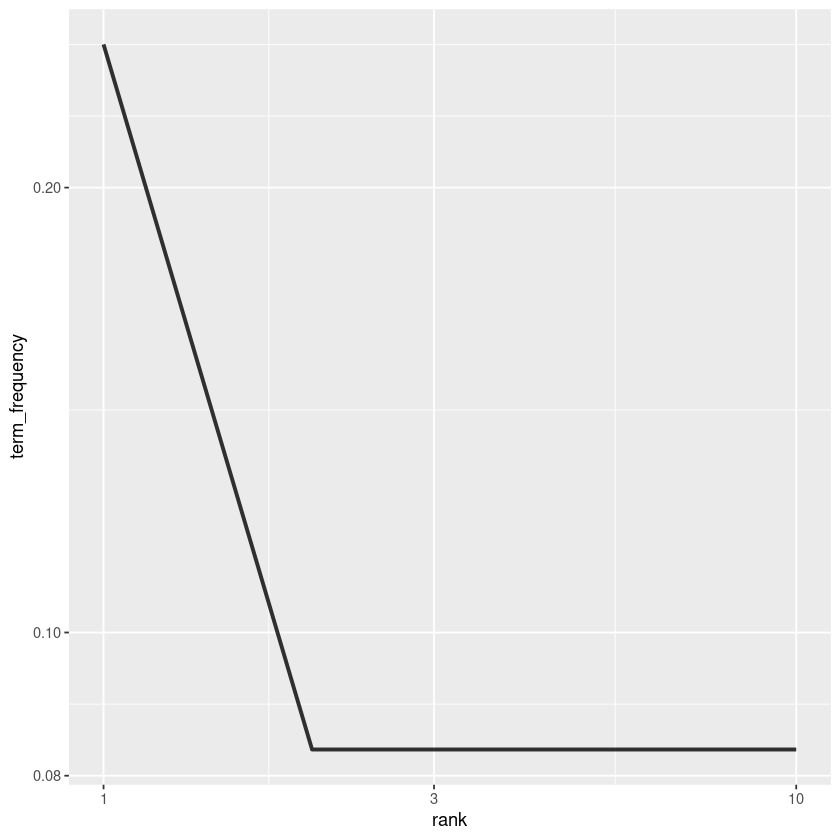

In [29]:
freq_by_rank %>%
  filter(id %in% c(2)) %>%
  ggplot(aes(rank, `term_frequency`)) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

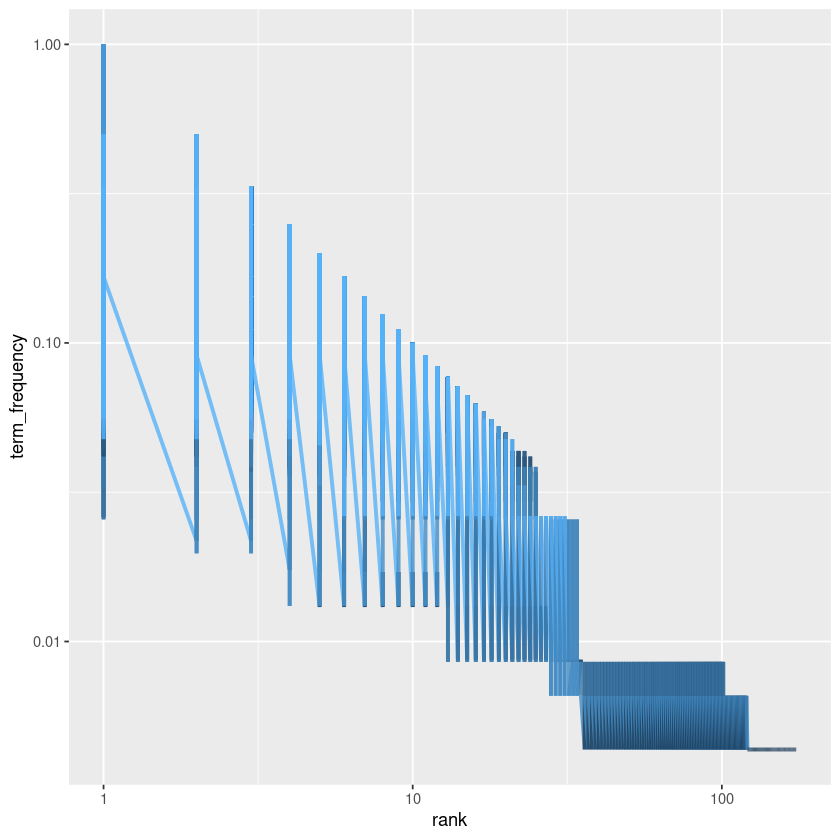

In [30]:
freq_by_rank %>%
  #filter(id %in% c(2969)) %>%
  ggplot(aes(rank, `term_frequency`, colour = id)) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

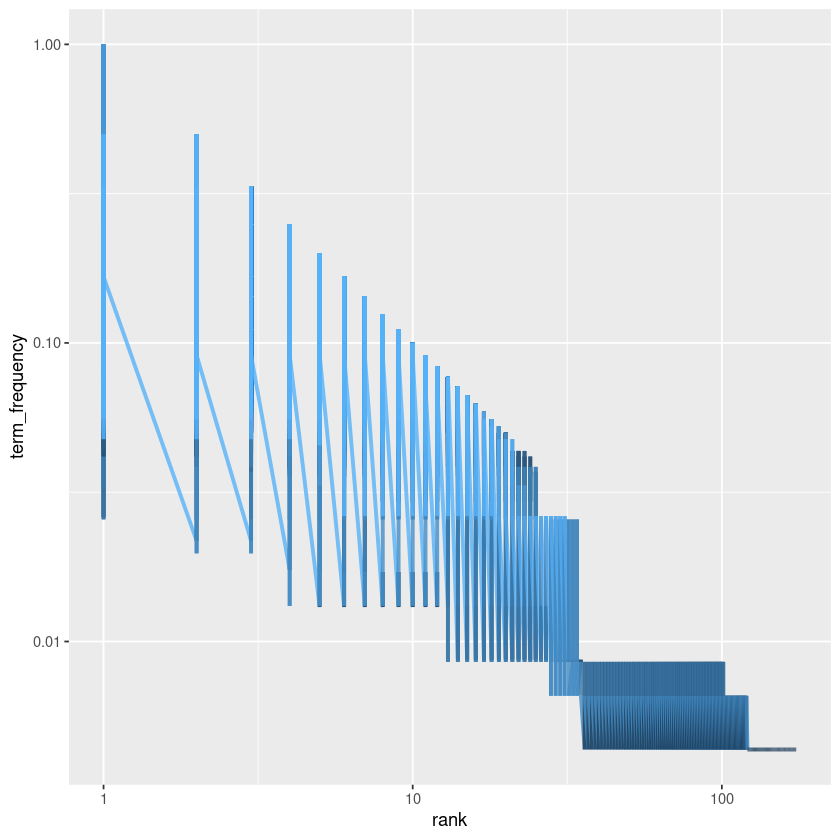

In [31]:
freq_by_rank %>%
  ggplot(aes(rank, `term_frequency`, colour = id)) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

TF-IDF

In [247]:
#head(train_data)

corpus <- Corpus(VectorSource(train_data$Text))
corpus
inspect(corpus[1:3])


## TRANSFORM DATA INTO DOCUMENT TERM MATRIX
dtm <- DocumentTermMatrix(corpus)
#inspect(dtm)

#findFreqTerms(dtm, 5) #mencari kata yang mempunyai frekuensi muncul lebih dari 5 kali

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 6549

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 3

[1] Says the Annies List political group supports third-trimester abortions on demand.                                                           
[2] When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
[3] Jim Dunnam has not lived in the district he represents for years now.                                                                        


In [249]:
fivefreq <- findFreqTerms(dtm, 10)
length((fivefreq))
fivefreq

# Use only 5 most frequent words (fivefreq) to build the DTM

dtm.train.nb <- DocumentTermMatrix(corpus, control=list(dictionary = fivefreq))
inspect(dtm.train.nb)

[1] 1351

[1] "abortions"        "group"            "list"            
   [4] "political"        "says"             "supports"        
   [7] "the"              "administration."  "bushs"           
  [10] "coal"             "did"              "gas"             
  [13] "george"           "natural"          "off"             
  [16] "started"          "that"             "took"            
  [19] "when"             "district"         "for"             
  [22] "has"              "jim"              "not"             
  [25] "now."             "years"            "along"           
  [28] "ethics"           "i'm"              "just"            
  [31] "last"             "only"             "person"          
  [34] "reform"           "russ"             "since"           
  [37] "some"             "this"             "who"             
  [40] "with"             "worked"           "year"            
  [43] "funds"            "land"             "million"         
  [46] "new"              "oregon"           "and"             
  [49] "cast"             "cost"             "gop"             
  [52] "higher"           "joe"              "primary"         
  [55] "vote"             "americans"        "class"           
  [58] "have"             "into"             "middle"          
  [61] "nearly"           "out"              "poverty."        
  [64] "actually"         "cut"              "didnt"           
  [67] "governor"         "growth"           "it."             
  [70] "mitt"             "our"              "rate"            
  [73] "romney"           "was"              "already"         
  [76] "been"             "care"             "most"            
  [79] "all"              "buy"              "government"      
  [82] "mccain"           "opposed"          "said"            
  [85] "were"             "bank"             "became"          
  [88] "percent"          "raised"           "rates"           
  [91] "water"            "world"            "100,000"         
  [94] "almost"           "left"             "people"          
  [97] "year."            "corporate"        "free"            
 [100] "highest"          "states"           "tax"             
 [103] "united"           "world."           "america"         
 [106] "auto"             "best"             "had"             
 [109] "history."         "industry"         "care."           
 [112] "children"         "cutting"          "families"        
 [115] "health"           "scott"            "walker"          
 [118] "dont"             "know"             "after"           
 [121] "against"          "american"         "crimes"          
 [124] "muslims"          "san"              "election"        
 [127] "elections."       "lost"             "never"           
 [130] "perry"            "rick"             "texas"           
 [133] "three"            "times"            "won"             
 [136] "about"            "percent."         "unemployment"    
 [139] "are"              "budget"           "business"        
 [142] "deficits"         "good"             "look"            
 [145] "right"            "they"             "very"            
 [148] "you"              "businesses"       "pay"             
 [151] "tax."             "taxes"            "today"           
 [154] "austin"           "basically"        "city"            
 [157] "doubled"          "every"            "size"            
 [160] "control"          "will"             "african"         
 [163] "based"            "cases"            "court"           
 [166] "justice"          "law."             "south"           
 [169] "supreme"          "u.s."             "defense"         
 [172] "fight"            "including"        "marco"           
 [175] "one"              "rubio"            "votes"           
 [178] "company"          "david"            "failed"          
 [181] "federal"          "loan"             "rep."            
 [184] "responsible"      "solar"            "abortion"        
 [187] "gov."             "john"   

<<DocumentTermMatrix (documents: 6549, terms: 1351)>>
Non-/sparse entries: 64857/8782842
Sparsity           : 99%
Maximal term length: 16
Weighting          : term frequency (tf)
Sample             :
      Terms
Docs   and are for has have percent says than that the
  238    0   0   0   3    0       3    0    0    0   4
  2682   1   4   1   0    0       1    0    0    3   2
  2806   0   1   0   0    0       0    0    1    0   3
  3198   1   1   1   1    0       0    0    0    0   2
  3490   1   3   0   0    1       0    0    0    2   0
  457    0   0   0   0    0       1    0    2    1   7
  4799   0   1   4   1    0       2    3    3    2  15
  5184   0   0   4   0    2       0    1    0    0   5
  5394   0   0   3   0    0       0    1    0    3   2
  830    7   2   2   1    1       2    1    2    5  14


In [250]:
train_data %>% filter(id == 2682)

Labels,Text,Text_Tag,id
<int>,<chr>,<chr>,<int>
5,"Let's pay attention to kids who are not going to college, which ends up being about 60 percent of the kids... and get them trained for the jobs that are there. Because, you know, there are auto mechanic jobs paying $50,000, $60,000 that they can't get filled. There are airline mechanic jobs paying a lot of money that can't get filled. Remarks at AFSCME forum 6/19/2007",economy,2682


In [231]:
book_wordss <- book_words %>%
            bind_tf_idf(stem, id, n) %>% 
            group_by(id) %>%
            mutate(rank = row_number())
book_wordss %>% filter(stem == "abort")

Labels,id,stem,n,total,tf,idf,tf_idf,rank
<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,1718,abort,3,34,0.088235294,4.319688,0.3811489,1
1,2237,abort,3,17,0.176470588,4.319688,0.7622978,1
0,3041,abort,2,18,0.111111111,4.319688,0.4799653,1
1,467,abort,2,6,0.333333333,4.319688,1.4398958,1
3,1033,abort,2,230,0.008695652,4.319688,0.0375625,14
4,1642,abort,2,9,0.222222222,4.319688,0.9599306,1
0,695,abort,1,7,0.142857143,4.319688,0.6170982,1
0,1376,abort,1,9,0.111111111,4.319688,0.4799653,1
0,1389,abort,1,9,0.111111111,4.319688,0.4799653,1


In [222]:
#Vocabulary

vocabulary <- book_words %>%
            select(stem) %>%
            group_by(stem) %>%
            count(stem) %>%
            mutate(stemID = c(1:length(stem))) %>%
            bind_tf_idf(stemID, stem, n)
              
vocabulary

stem,n,stemID,tf,idf,tf_idf
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
aa,1,1,1,0,0
aaa,2,1,1,0,0
aaron,2,1,1,0,0
aarp,4,1,1,0,0
aba,1,1,1,0,0
abandon,1,1,1,0,0
abbott,13,1,1,0,0
abc,2,1,1,0,0
abdul,1,1,1,0,0


In [213]:
book_wordss %>% arrange(stem)

Labels,id,stem,n,total,tf,idf,tf_idf,rank
<int>,<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
1,6647,aa,1,5,0.200000000,9.011035,1.80220708,1
0,5453,aaa,1,21,0.047619048,8.317888,0.39608992,4
1,6647,aaa,1,5,0.200000000,8.317888,1.66357765,2
1,5194,aaron,1,10,0.100000000,8.317888,0.83178882,1
3,2765,aaron,1,7,0.142857143,8.317888,1.18826975,1
0,4761,aarp,1,6,0.166666667,7.624741,1.27079017,1
1,2376,aarp,1,8,0.125000000,7.624741,0.95309263,1
2,437,aarp,1,11,0.090909091,7.624741,0.69315828,3
3,2056,aarp,1,10,0.100000000,7.624741,0.76247410,1


In [211]:
book_wordss %>% group_by(stem) %>% select(stem, idf) %>% distinct() %>% arrange(stem)

stem,idf
<chr>,<dbl>
aa,9.011035
aaa,8.317888
aaron,8.317888
aarp,7.624741
aba,9.011035
abandon,9.011035
abbott,6.446086
abc,8.317888
abdul,9.011035


In [53]:
with_label <- df %>%
  group_by(id, word) %>%
  select(id, Labels, word)
#with_label: 68915 × 3

In [47]:
book_wordsss <- inner_join(book_wordss, with_label, by = c("id", "word"))

book_wordsss %>% filter()
#book_wordssss <- if (nrow(book_wordsss) <= nrow(book_wordss)) joined_df else book_wordss

id,word,n,total,tf,idf,tf_idf,rank,Labels
<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>
313,percent,6,17,0.35294118,2.359321,0.83270154,1,2
313,percent,6,17,0.35294118,2.359321,0.83270154,1,2
313,percent,6,17,0.35294118,2.359321,0.83270154,1,2
313,percent,6,17,0.35294118,2.359321,0.83270154,1,2
313,percent,6,17,0.35294118,2.359321,0.83270154,1,2
313,percent,6,17,0.35294118,2.359321,0.83270154,1,2
1039,republican,6,230,0.02608696,3.378684,0.08813958,1,3
1039,republican,6,230,0.02608696,3.378684,0.08813958,1,3
1039,republican,6,230,0.02608696,3.378684,0.08813958,1,3


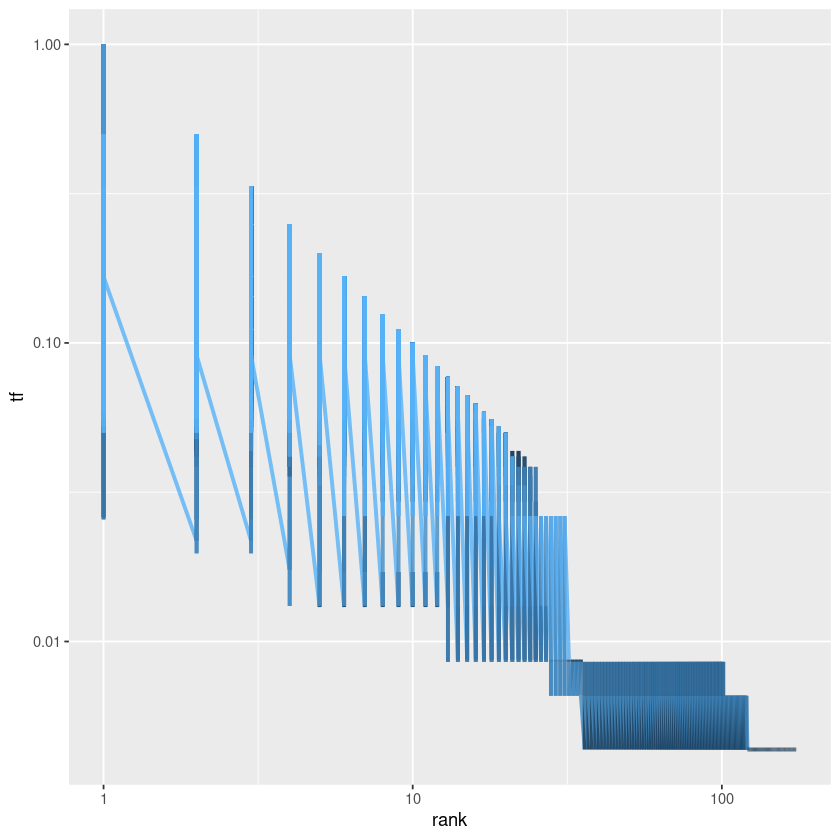

In [81]:
book_words %>%
  #filter(id %in% c(2969)) %>%
  ggplot(aes(rank, tf, colour = id)) +
  geom_line(size = 1.1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

In [45]:
df %>% filter(str_detect(Text_Tag))

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mℹ[39m In argument: `str_detect(Text_Tag)`.
[1mCaused by error in `str_detect()`:[22m
[33m![39m argument "pattern" is missing, with no default


In [43]:
head(strsplit(df$Text_Tag, split = ","), 1000)

[[1]]
[1] "abortion"

[[2]]
[1] "abortion"

[[3]]
[1] "abortion"

[[4]]
[1] "abortion"

[[5]]
[1] "abortion"

[[6]]
[1] "abortion"

[[7]]
[1] "abortion"

[[8]]
[1] "foreign-policy"

[[9]]
[1] "foreign-policy"

[[10]]
[1] "foreign-policy"

[[11]]
[1] "foreign-policy"

[[12]]
[1] "foreign-policy"

[[13]]
[1] "foreign-policy"

[[14]]
[1] "foreign-policy"

[[15]]
[1] "foreign-policy"

[[16]]
[1] "foreign-policy"

[[17]]
[1] "foreign-policy"

[[18]]
[1] "foreign-policy"

[[19]]
[1] "health-care"

[[20]]
[1] "health-care"

[[21]]
[1] "health-care"

[[22]]
[1] "health-care"

[[23]]
[1] "health-care"

[[24]]
[1] "health-care"

[[25]]
[1] "health-care"

[[26]]
[1] "health-care"

[[27]]
[1] "health-care"

[[28]]
[1] "economy" "jobs"   

[[29]]
[1] "economy" "jobs"   

[[30]]
[1] "economy" "jobs"   

[[31]]
[1] "economy" "jobs"   

[[32]]
[1] "ethics"

[[33]]
[1] "ethics"

[[34]]
[1] "ethics"

[[35]]
[1] "ethics"

[[36]]
[1] "ethics"

[[37]]
[1] "ethics"

[[38]]
[1] "ethics"

[[39]]
[1] "ethics"

[[40]]
[1] "ethics"

[[41]]
[1] "ethics"

[[42]]
[1] "elections"

[[43]]
[1] "elections"

[[44]]
[1] "elections"

[[45]]
[1] "elections"

[[46]]
[1] "elections"

[[47]]
[1] "elections"

[[48]]
[1] "elections"

[[49]]
[1] "elections"

[[50]]
[1] "elections"

[[51]]
[1] "elections"

[[52]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[53]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[54]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[55]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[56]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[57]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[58]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[59]]
[1] "economy"            "jobs"               "new-hampshire-2012"
[4] "poverty"           

[[60]]
[1] "history"      "state-budget"

[[61]]
[1] "history"      "state-budget"

[[62]]
[1] "history"      "state-budget"

[[63]]
[1] "history"      "state-budget"

[[64]]
[1] "history"      "state-budget"

[[65]]
[1] "history"      "state-budget"

[[66]]
[1] "history"      "state-budget"

[[67]]
[1] "history"      "state-budget"

[[68]]
[1] "history"      "state-budget"

[[69]]
[1] "history"      "state-budget"

[[70]]
[1] "economy"        "federal-budget" "health-care"   

[[71]]
[1] "economy"        "federal-budget" "health-care"   

[[72]]
[1] "economy"        "federal-budget" "health-care"   

[[73]]
[1] "economy"        "federal-budget" "health-care"   

[[74]]
[1] "economy"        "federal-budget" "health-care"   

[[75]]
[1] "economy"        "federal-budget" "health-care"   

[[76]]
[1] "economy"        "federal-budget" "health-care"   

[[77]]
[1] "health-care"

[[78]]
[1] "health-care"

[[79]]
[1] "health-care"

[[80]]
[1] "health-care"

[[81]]
[1] "health-care"

[[82]]
[1] "health-care"

[[83]]
[1] "elections"

[[84]]
[1] "elections"

[[85]]
[1] "elections"

[[86]]
[1] "elections"

[[87]]
[1] "elections"

[[88]]
[1] "elections"

[[89]]
[1] "elections"

[[90]]
[1] "elections"

[[91]]
[1] "elections"

[[92]]
[1] "elections"

[[93]]
[1] "elections"

[[94]]
[1] "elections"

[[95]]
[1] "elections"

[[96]]
[1] "elections"

[[97]]
[1] "elections"

[[98]]
[1] "elections"

[[99]]
[1] "elections"

[[100]]
[1] "elections"

[[101]]
[1] "federal-budget"

[[102]]
[1] "federal-budget"

[[103]]
[1] "federal-budget"

[[104]]
[1] "federal-budget"

[[105]]
[1] "federal-budget"

[[106]]
[1] "federal-budget"

[[107]]
[1] "federal-budget"

[[108]]
[1] "federal-budget"

[[109]]
[1] "federal-budget"

[[110]]
[1] "federal-budget"

[[111]]
[1] "federal-budget"

[[112]]
[1] "federal-budget"

[[113]]
[1] "bankruptcy" "economy"    "population"

[[114]]
[1] "bankruptcy" "economy"    "population"

[[1

In [54]:
df %>% 
    mutate(Text_tag_2 = strsplit(Text_Tag, split = ",")) %>%
    mutate(values = length(Text_tag_2[1]))

Labels,Text_Tag,word,Text_tag_2,values
<int>,<chr>,<chr>,<list>,<int>
1,abortion,annies,abortion,1
1,abortion,list,abortion,1
1,abortion,political,abortion,1
1,abortion,supports,abortion,1
1,abortion,trimester,abortion,1
1,abortion,abortions,abortion,1
1,abortion,demand,abortion,1
3,foreign-policy,hillary,foreign-policy,1
3,foreign-policy,clinton,foreign-policy,1


In [38]:
df %>%
    pivot_longer(
            cols = Text_Tag, 
            names_pattern= "[a-zA-z]*)", 
            #values_to = "count"
  )

ERROR: [1m[33mError[39m in `pivot_longer()`:[22m
[1m[22m[33m![39m `regex` should define 1 groups; 0 found.


In [76]:
data("stop_words")

In [82]:
data("stop_words")

#df <- data[2]
df <- data.frame(
  Review = c("Won't let me use my camera 64", "Does not load.","It's truly mind blowing!", "Beijing and Taipei join the WTO"))

#head(df)

df$Proc_Review <- gsub("\\'", "", df$Review) # Removes Apostrophes white spaces
df$Proc_Review <- gsub('[[:punct:] ]+',' ',df$Proc_Review) # Remove Punctuation 
df$Proc_Review <- gsub('[[:digit:]]+', '', df$Proc_Review) # Remove numbers
df$Proc_Review <- as.character(df$Proc_Review)

df %>%
  unnest_tokens(word, Proc_Review, drop = TRUE, to_lower = FALSE)  %>%
  anti_join(stop_words)

Joining with `by = join_by(word)`


Review,word
<chr>,<chr>
Won't let me use my camera 64,Wont
Won't let me use my camera 64,camera
Does not load.,Does
Does not load.,load
It's truly mind blowing!,Its
It's truly mind blowing!,mind
It's truly mind blowing!,blowing
Beijing and Taipei join the WTO,Beijing
Beijing and Taipei join the WTO,Taipei


In [89]:
print(stop_words[[1]])

   [1] "a"             "a's"           "able"          "about"        
   [5] "above"         "according"     "accordingly"   "across"       
   [9] "actually"      "after"         "afterwards"    "again"        
  [13] "against"       "ain't"         "all"           "allow"        
  [17] "allows"        "almost"        "alone"         "along"        
  [21] "already"       "also"          "although"      "always"       
  [25] "am"            "among"         "amongst"       "an"           
  [29] "and"           "another"       "any"           "anybody"      
  [33] "anyhow"        "anyone"        "anything"      "anyway"       
  [37] "anyways"       "anywhere"      "apart"         "appear"       
  [41] "appreciate"    "appropriate"   "are"           "aren't"       
  [45] "around"        "as"            "aside"         "ask"          
  [49] "asking"        "associated"    "at"            "available"    
  [53] "away"          "awfully"       "b"             "be"           
  [57]

In [128]:
stop_words[[1]][stop_words[[1]]=="with"]

[1] "with" "with" "with"

In [ ]:
df <- clean_text(df)

In [46]:
df

Review,Proc_Review
<chr>,<chr>
Won't let me use my camera 64,Wont let me use my camera
Does not load.,Does not load
It's truly mind blowing!,Its truly mind blowing
Beijing and Taipei join the WTO,Beijing and Taipei join the WTO


In [65]:
#Convert to lowercase and split into tokens

tokens <- c() #matrix("", nrow = length(data[[2]]), ncol = 1)
for(i in 1:length(data[[1]])){
    text <- tolower(data$Text[i])
    #str(text)
    text2 <- split_token(text)
    #str(text2)
    tokens[i] <- text2
    #str(tokens)
}
#print(tokens)

In [66]:
head(tokens)

[[1]]
 [1] "says"      "the"       "annies"    "list"      "political" "group"    
 [7] "supports"  "third"     "-"         "trimester" "abortions" "on"       
[13] "demand"    "."        

[[2]]
 [1] "when"           "did"            "the"            "decline"       
 [5] "of"             "coal"           "start"          "?"             
 [9] "it"             "started"        "when"           "natural"       
[13] "gas"            "took"           "off"            "that"          
[17] "started"        "to"             "begin"          "in"            
[21] "("              "president"      "george"         "w"             
[25] "."              ")"              "bushs"          "administration"
[29] "."             

[[3]]
 [1] "hillary" "clinton" "agrees"  "with"    "john"    "mccain"  "\""     
 [8] "by"      "voting"  "to"      "give"    "george"  "bush"    "the"    
[15] "benefit" "of"      "the"     "doubt"   "on"      "iran"    "."      
[22] "\""     

[[4]]
 [1] "health"      "care"        "reform"      "legislation" "is"         
 [6] "likely"      "to"          "mandate"     "free"        "sex"        
[11] "change"      "surgeries"   "."          

[[5]]
 [1] "the"        "economic"   "turnaround" "started"    "at"        
 [6] "the"        "end"        "of"         "my"         "term"      
[11] "."         

[[6]]
 [1] "the"          "chicago"      "bears"        "have"         "had"         
 [6] "more"         "starting"     "quarterbacks" "in"           "the"         
[11] "last"         "10"           "years"        "than"         "the"         
[16] "total"        "number"       "of"           "tenured"      "("           
[21] "uw"           ")"            "faculty"      "fired"        "during"      
[26] "the"          "last"         "two"          "decades"      "."

In [71]:
data("stop_words")

anti_join(tokens, stop_words)

ERROR: Error in UseMethod("anti_join"): no applicable method for 'anti_join' applied to an object of class "list"


In [69]:
data[2]

Text
<chr>
Says the Annies List political group supports third-trimester abortions on demand.
When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.
"Hillary Clinton agrees with John McCain ""by voting to give George Bush the benefit of the doubt on Iran."""
Health care reform legislation is likely to mandate free sex change surgeries.
The economic turnaround started at the end of my term.
The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.
Jim Dunnam has not lived in the district he represents for years now.
"I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate."
"However, it took $19.5 million in Oregon Lottery funds for the Port of Newport to eventually land the new NOAA Marine Operations Center-Pacific."


In [70]:
data.frame(
  Review = c("Won't let me use my camera 64", "Does not load.","It's truly mind blowing!", "Beijing and Taipei join the WTO"))

Review
<chr>
Won't let me use my camera 64
Does not load.
It's truly mind blowing!
Beijing and Taipei join the WTO


In [68]:
data("stop_words")

df <- data[2]
#df <- data.frame(
#  Review = c("Won't let me use my camera 64", "Does not load.","It's truly mind blowing!", "Beijing and Taipei join the WTO"))


df$Proc_Review <- gsub("\\'", "", df$Review) # Removes Apostrophes white spaces
df$Proc_Review <- gsub('[[:punct:] ]+',' ',df$Proc_Review) # Remove Punctuation 
df$Proc_Review <- gsub('[[:digit:]]+', '', df$Proc_Review) # Remove numbers
df$Proc_Review <- as.character(df$Proc_Review)

#df %>%
#  unnest_tokens(word, Proc_Review, drop = TRUE, to_lower = TRUE)  %>%
#  anti_join(stop_words)

ERROR: Error in `$<-.data.frame`(`*tmp*`, Proc_Review, value = character(0)): replacement has 0 rows, data has 10240


In [252]:
# Install and load the required packages
#install.packages("naivebayes")
library(naivebayes)

# Create sample training data
train_documents <- c("I love this movie",
                     "This movie is great",
                     "The plot was terrible",
                     "I didn't like the acting")

train_labels <- factor(c("positive", "positive", "negative", "negative"))

# Create a document-term matrix
train_dtm <- DocumentTermMatrix(Corpus(VectorSource(train_documents)))

# Convert the document-term matrix to a data frame
train_df <- as.data.frame(as.matrix(train_dtm))
#print(train_df)
train_df$label <- train_labels

# Train the Multinomial Naive Bayes classifier
model <- naive_bayes(label ~ ., data = train_df, laplace = 1)

# Create sample test data
test_documents <- c("The acting was superb",
                    "I really enjoyed the movie")

test_dtm <- DocumentTermMatrix(Corpus(VectorSource(test_documents)))
test_df <- as.data.frame(as.matrix(test_dtm))

# Predict the labels for test data
predicted_labels <- predict(model, newdata = test_df)

# Print the predicted labels
print(predicted_labels)

Warning message:
“predict.naive_bayes(): only 4 feature(s) out of 11 defined in the naive_bayes object "model" are used for prediction.
”


[1] negative positive
Levels: negative positive
